In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path

def setup_mpl():
    mpl.rcParams['font.family'] = 'Times New Roman'
    mpl.rcParams['lines.linewidth'] = 2
    return None
setup_mpl()

In [3]:
data_dict = {}

for d in Path('../data/raw/dataset').glob('D1_*'):
    d_name = d.name
    data_dict[d_name] = {}
    
    for id_ in d.glob('ID_*'):
        id_name = id_.name
        data_dict[d_name][id_name] = {}
        
        for round_ in id_.glob('round_*'):
            round_name = round_.name
            data_dict[d_name][id_name][round_name] = {}
            
            for phase in round_.glob('phase*'):
                phase_name = phase.name
                data_dict[d_name][id_name][round_name][phase_name] = {} 
                
                for file in phase.glob('*.csv'):
                    if file.name not in ('response.csv',):
                        temp_df = pd.read_csv(file, index_col=None)
                        temp_df['time'] = pd.to_datetime(temp_df['time'], format='%Y-%m-%d %H:%M:%S.%f')
                        temp_df['time_passed'] = (temp_df['time'] - temp_df['time'].iloc[0]).apply(lambda x: x.total_seconds())
                        
                        # Save dataframe in nested dictionary
                        data_dict[d_name][id_name][round_name][phase_name][file.stem] = temp_df

In [4]:
data_dict['D1_1']['ID_8']['round_1']['phase3']['EDA']

,Unnamed: 0,EDA,time,time_passed
0,0,0.549724,2021-12-17 16:32:13.000,0.00
1,1,0.538191,2021-12-17 16:32:13.250,0.25
2,2,0.535629,2021-12-17 16:32:13.500,0.50
3,3,0.516408,2021-12-17 16:32:13.750,0.75
4,4,0.489498,2021-12-17 16:32:14.000,1.00
...,...,...,...,...
1463,1463,0.449774,2021-12-17 16:38:18.750,365.75
1464,1464,0.448493,2021-12-17 16:38:19.000,366.00
1465,1465,0.447212,2021-12-17 16:38:19.250,366.25
1466,1466,0.458744,2021-12-17 16:38:19.500,366.50


First let us start simple and then extend; meaning that first we will look into a single round, and get a working example, then we will extend to multiple individuals and then to multiple cohorts.

In [387]:
min_len_eda = min(len(data_dict[cohort][id][round_][phase]['HR']['HR'].tolist()) for cohort in data_dict for id in data_dict[cohort] for round_ in data_dict[cohort][id] for phase in data_dict[cohort][id][round_])

columns = ['ID', 'time', 'time_passed', 'D', 'round', 'phase', 'HR']
df = pd.DataFrame(columns=columns)
X = []
labels = []

for cohort in data_dict.keys():
    for id in data_dict[cohort].keys():
        for round_ in data_dict[cohort][id].keys():
            for phase in data_dict[cohort][id][round_].keys():
                eda_ts = data_dict[cohort][id][round_][phase]['HR'].HR
                time_ts = data_dict[cohort][id][round_][phase]['HR'].time
                time_passed = data_dict[cohort][id][round_][phase]['HR'].time_passed
                # Temporary fix, appears that there might be an outlier that messes up the results
                #if max(eda_ts) > 40:
                #    continue
                # Truncating
                if len(eda_ts) > min_len_eda:
                    eda_ts = eda_ts[:min_len_eda]
                    time_ts = time_ts[:min_len_eda]
                    time_passed = time_passed[:min_len_eda]
                
                temp_df = pd.DataFrame({
                            'ID': id, 
                            'time': time_ts,
                            'time_passed': time_passed,
                            'D': cohort,
                            'round': round_,
                            'phase': phase,
                            'HR': eda_ts, 
                        })
                labels.append(phase)
                X += [eda_ts]

                df = pd.concat([df, temp_df], ignore_index=True)
        
labels = np.array(labels)
X = np.vstack(X)
X.shape

(312, 224)

In [368]:
df

,ID,time,time_passed,D,round,phase,HR
0,ID_8,2021-12-17 16:32:13,0.0,D1_1,round_1,phase3,69.35
1,ID_8,2021-12-17 16:32:14,1.0,D1_1,round_1,phase3,69.50
2,ID_8,2021-12-17 16:32:15,2.0,D1_1,round_1,phase3,69.63
3,ID_8,2021-12-17 16:32:16,3.0,D1_1,round_1,phase3,69.80
4,ID_8,2021-12-17 16:32:17,4.0,D1_1,round_1,phase3,69.97
...,...,...,...,...,...,...,...
69883,ID_3,2022-10-26 10:17:50,219.0,D1_3_1,round_2,phase1,86.03
69884,ID_3,2022-10-26 10:17:51,220.0,D1_3_1,round_2,phase1,86.15
69885,ID_3,2022-10-26 10:17:52,221.0,D1_3_1,round_2,phase1,86.27
69886,ID_3,2022-10-26 10:17:53,222.0,D1_3_1,round_2,phase1,86.38


In [388]:
X.shape, len(labels)

((312, 224), 312)

In [389]:
from sklearn.decomposition import FastICA
from sklearn.decomposition import PCA

In [395]:
from py_pcha import PCHA
# Notice that for this implementation we transform the data matrix X
XC, S, C, SSE, varexl = PCHA(X.T, noc=2, delta=0.1)
X_hat = X.T @ C @ S
components = XC.T

[[ 95.02436146  52.91889295]
 [ 52.91889295 111.13785264]]
31785968.60301739


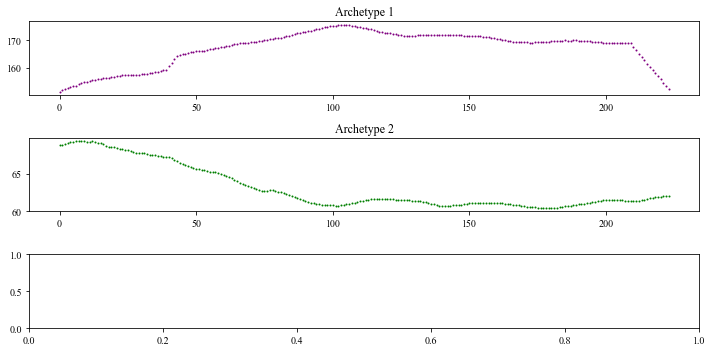

In [397]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 5))
ax1.plot(components[0, :].T, 'o', markersize=1, label='Archetype 1', c='purple')
ax1.set_title('Archetype 1')
ax2.plot(components[1, :].T, 'o', markersize=1, label='Archetype 2', c='green')
ax2.set_title('Archetype 2')
#ax3.plot(components[2, :].T, 'o', markersize=1, label='Archetype 3', c='blue')
#ax3.set_title('Archetype 3')
fig.tight_layout()
plt.show()

In [398]:
X_hat.shape

(224, 312)

In [399]:
phase1_idx = np.where(labels=='phase1')[0]
phase2_idx = np.where(labels=='phase2')[0]
phase3_idx = np.where(labels=='phase3')[0]

# Time series clustering / dimensionality reduction

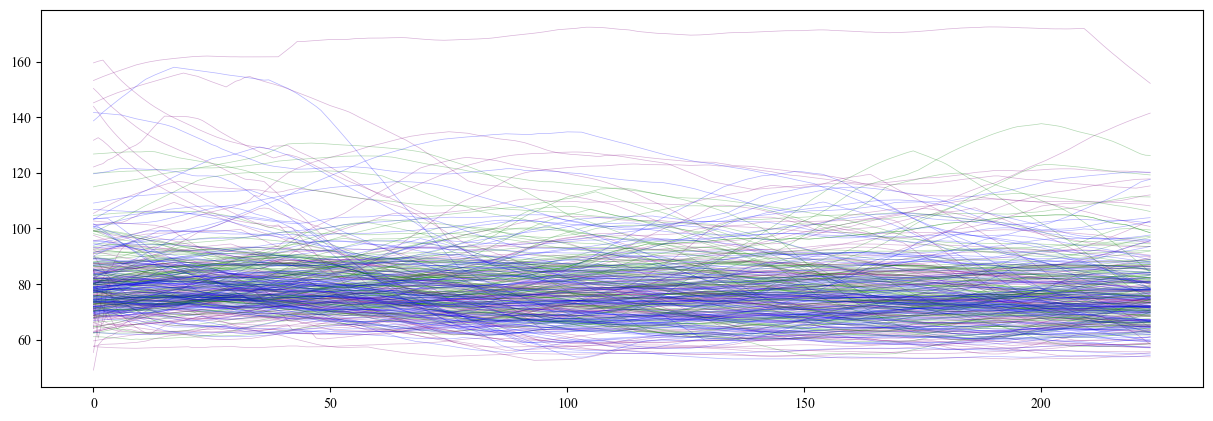

In [400]:
fig, ax = plt.subplots(figsize=(15, 5), dpi=100)
for idx in phase1_idx:
    ax.plot(time_passed, X[idx, :], alpha=0.3, c='purple', linewidth=0.5)

for idx in phase2_idx:
    ax.plot(time_passed, X[idx, :], alpha=0.3, c='green', linewidth=0.5)

for idx in phase3_idx:
    ax.plot(time_passed, X[idx, :], alpha=0.3, c='blue', linewidth=0.5)

In [401]:
from py_pcha import PCHA
X_temp = X.copy()
# Notice that for this implementation we transform the data matrix X
XC, S, C, SSE, varexl = PCHA(X_temp.T, noc=2, delta=0.1)
X_hat = X_temp.T @ C @ S
components = XC.T

[[108.20383065  52.309878  ]
 [ 52.309878    99.17641336]]
31209940.859677136


In [402]:
XC.shape, S.shape, C.shape

((224, 2), (2, 312), (312, 2))

In [378]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(S)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


PCA(n_components=2)

In [379]:
PC1, PC2 = pca.components_[0, :], pca.components_[1, :]

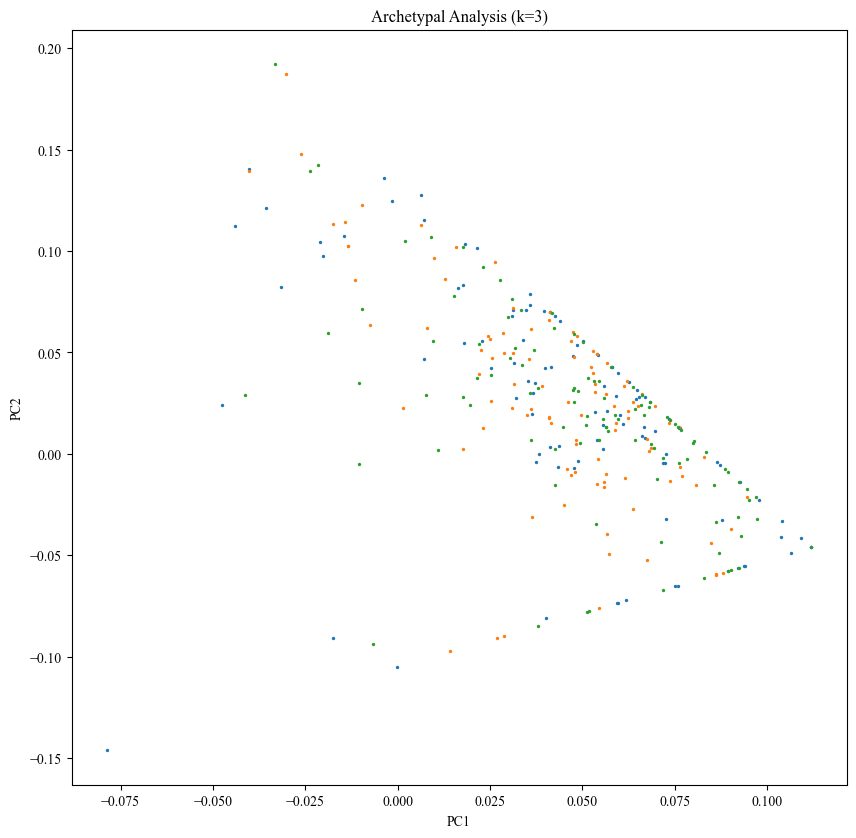

In [380]:
fig, ax = plt.subplots(figsize=(10,10), dpi=100)
ax.scatter(PC1[phase1_idx], PC2[phase1_idx], s=2)
ax.scatter(PC1[phase2_idx], PC2[phase2_idx], s=2)
ax.scatter(PC1[phase3_idx], PC2[phase3_idx], s=2)
ax.set_title('Archetypal Analysis (k=3)')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
plt.show()

# Series plots

We will use archetypal maximum membership assignment:

In [403]:
amma = np.argmax(S, axis=0)

Then we will try to find a single point nearest to each archetype:

In [405]:
np.asarray(S[:, np.argwhere(amma==0)[:, 1]][0,:]).flatten().shape

(6,)

In [414]:
N = 2
max0 = np.argpartition(np.asarray(S[:, np.argwhere(amma==0)[:, 1]][0,:]).flatten(), -N)[-N:]
max1 = np.argpartition(np.asarray(S[:, np.argwhere(amma==1)[:, 1]][1,:]).flatten(), -N)[-N:]
#max2 = np.argpartition(np.asarray(S[:, np.argwhere(amma==2)[:, 1]][2,:]).flatten(), -N)[-N:]

In [415]:
marker_dict = {
    'phase1':'o',
    'phase2':'^',
    'phase3':'s',
    }

labels[max0]

array(['phase2', 'phase3'], dtype='<U6')

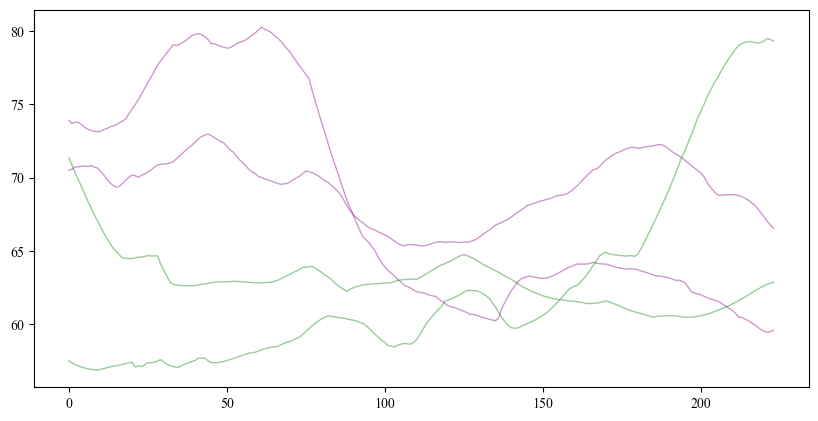

In [416]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=100)
for i in range(N):
    ax.plot(time_passed, X[max0[i], :], c='purple', linewidth=1, alpha=0.4)
    ax.plot(time_passed, X[max1[i], :], c='green', linewidth=1, alpha=0.4)
    #ax.plot(time_passed, X[max2[i], :], c='blue', linewidth=1, alpha=0.4)
plt.show()